# Variables with the same importance, testing intra-chain Variable Importance calculation  

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Data generation

In [3]:
X = pd.DataFrame(
    np.random.uniform(low=0, high=1.0, size=(100, 5)), columns=list("01234")
)
f_x = np.sum(X, axis=1)
Y = rng.normal(f_x, 1)

## Different number of variables  

Using default options of BART and 4 chains.

In [4]:
with pm.Model() as model:
    μ = pmb.BART("μ", X, Y)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=Y)
    idata = pm.sample(chains=4, random_seed=RANDOM_SEED)
    # Mean and STD Variable Importance
    VI = idata.sample_stats["variable_inclusion"].mean(("chain", "draw")).values
    VIs = VI / VI.sum()
    VIs_std = idata.sample_stats["variable_inclusion"].std(("chain", "draw")).values

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


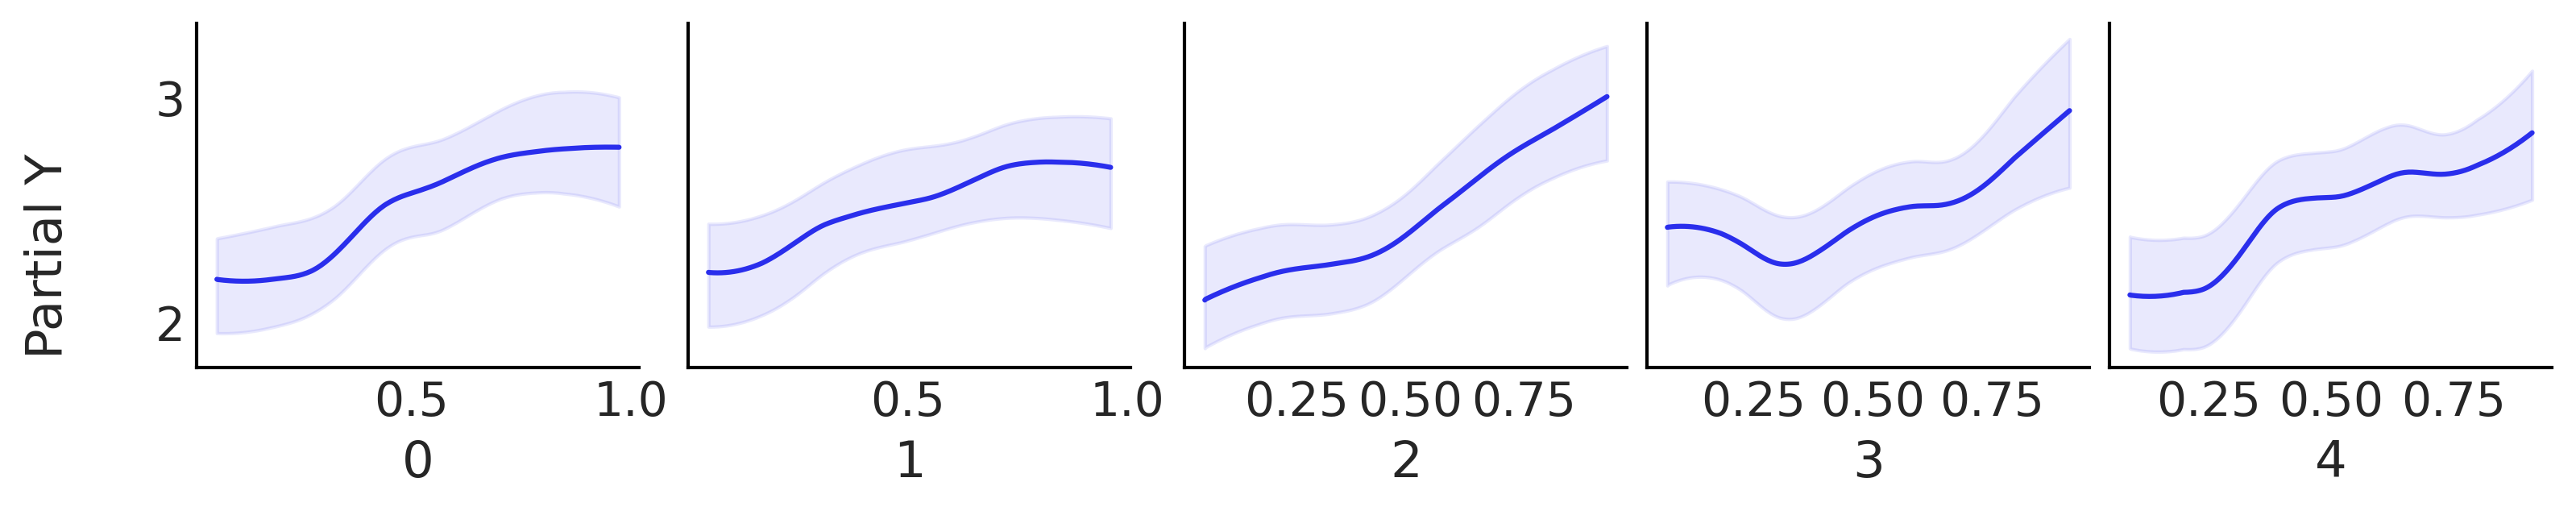

In [5]:
var_id = range(min(10, 5))
pmb.plot_pdp(μ, X, Y, var_idx=var_id, grid=(1, 5), figsize=(10, 2));

In [6]:
Xs = np.array(range(X.shape[1]))  # N variables

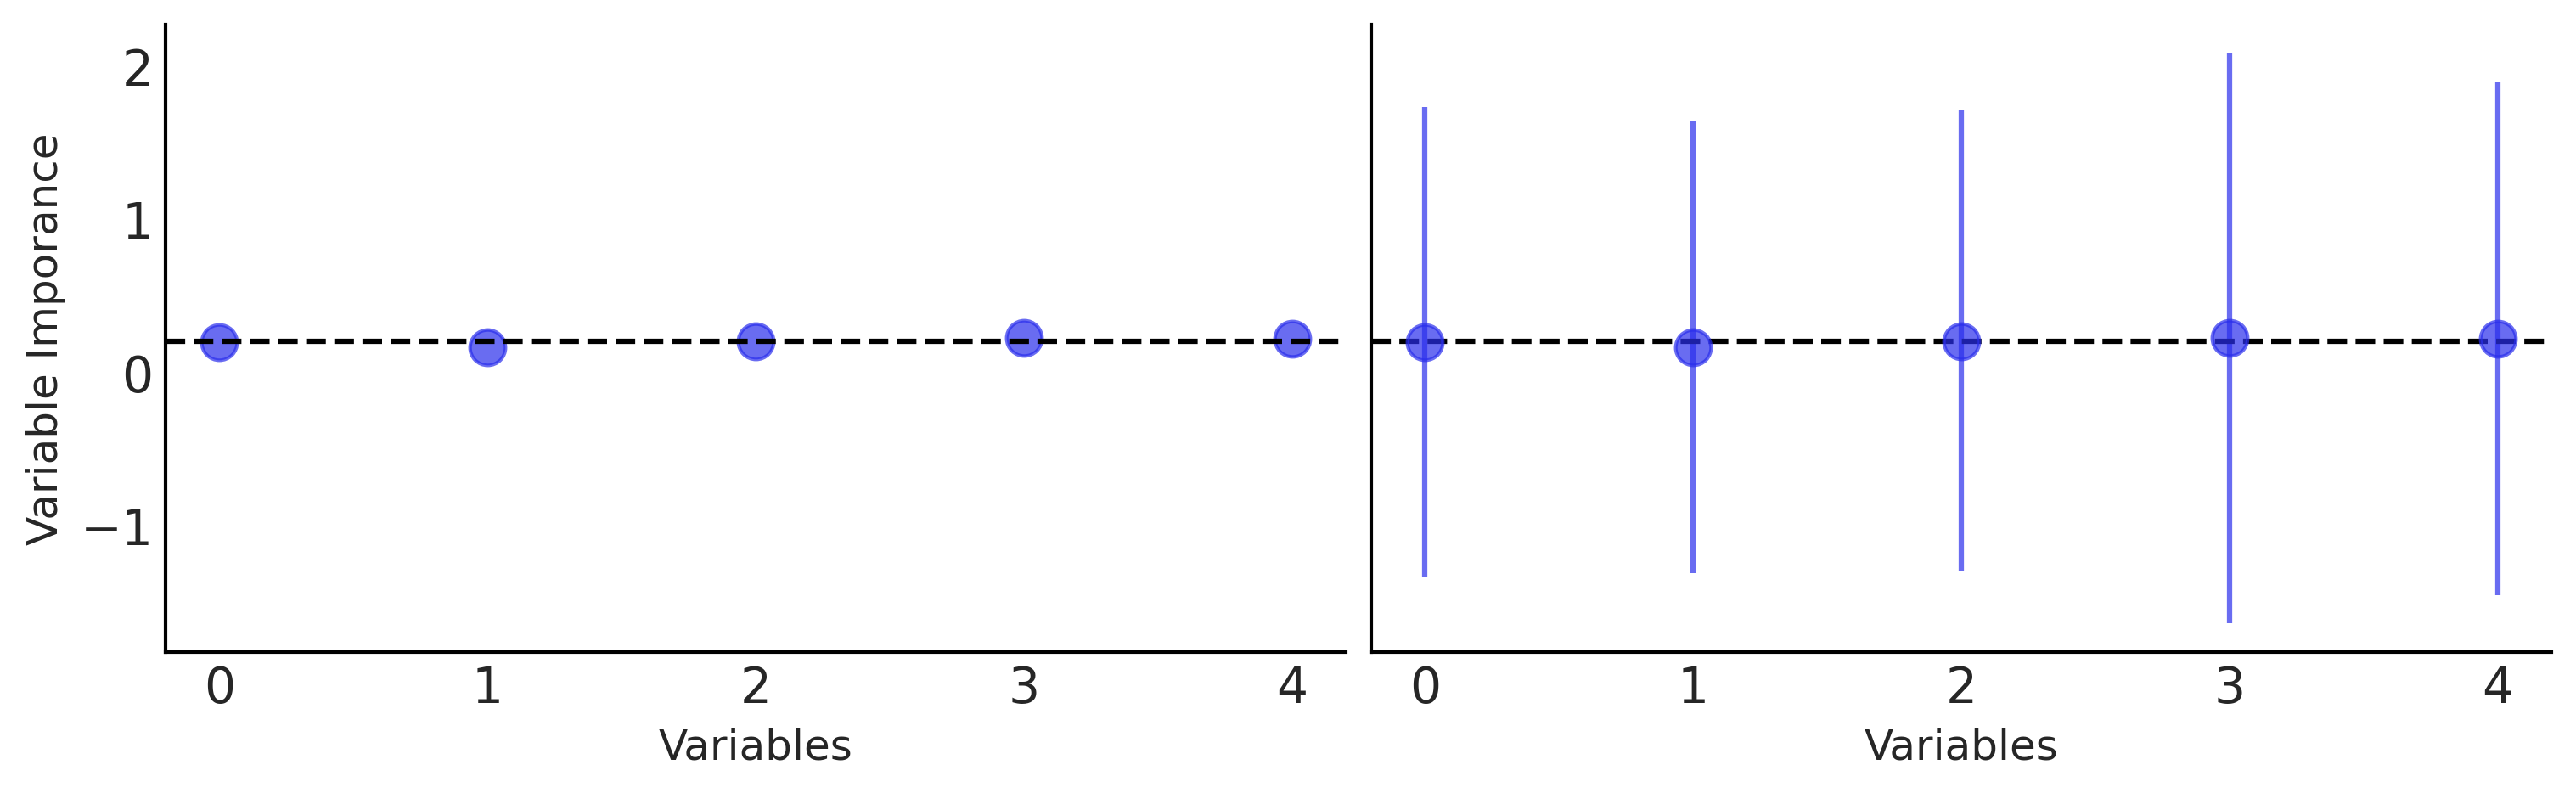

In [7]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 3))

axes[0].scatter(Xs, VIs, s=100, alpha=0.7)
axes[1].errorbar(
    x=Xs, y=VIs, yerr=VIs_std, linestyle="None", marker="o", markersize="10", alpha=0.7
)

for ax in axes:
    ax.axhline(1 / X.shape[1], ls="--", color="k")
    ax.set_xticks(Xs)
    ax.set_xlabel("Variables", fontsize=12)

axes[0].set_ylabel("Variable Imporance", fontsize=12)
plt.savefig("similar_VI_all_chains.png");

In [8]:
# Get the number of chains in the idata
chains = list(idata.sample_stats["variable_inclusion"]["chain"].values)
# Calculate VI mean and std for each chain
vis_chains = []
vis_chains_std = []
for chain in chains:
    vi_0 = idata.sample_stats["variable_inclusion"][chain].mean("draw").values
    vis_chains.append(vi_0 / vi_0.sum())
    vis_chains_std.append(
        idata.sample_stats["variable_inclusion"][chain].std("draw").values
    )

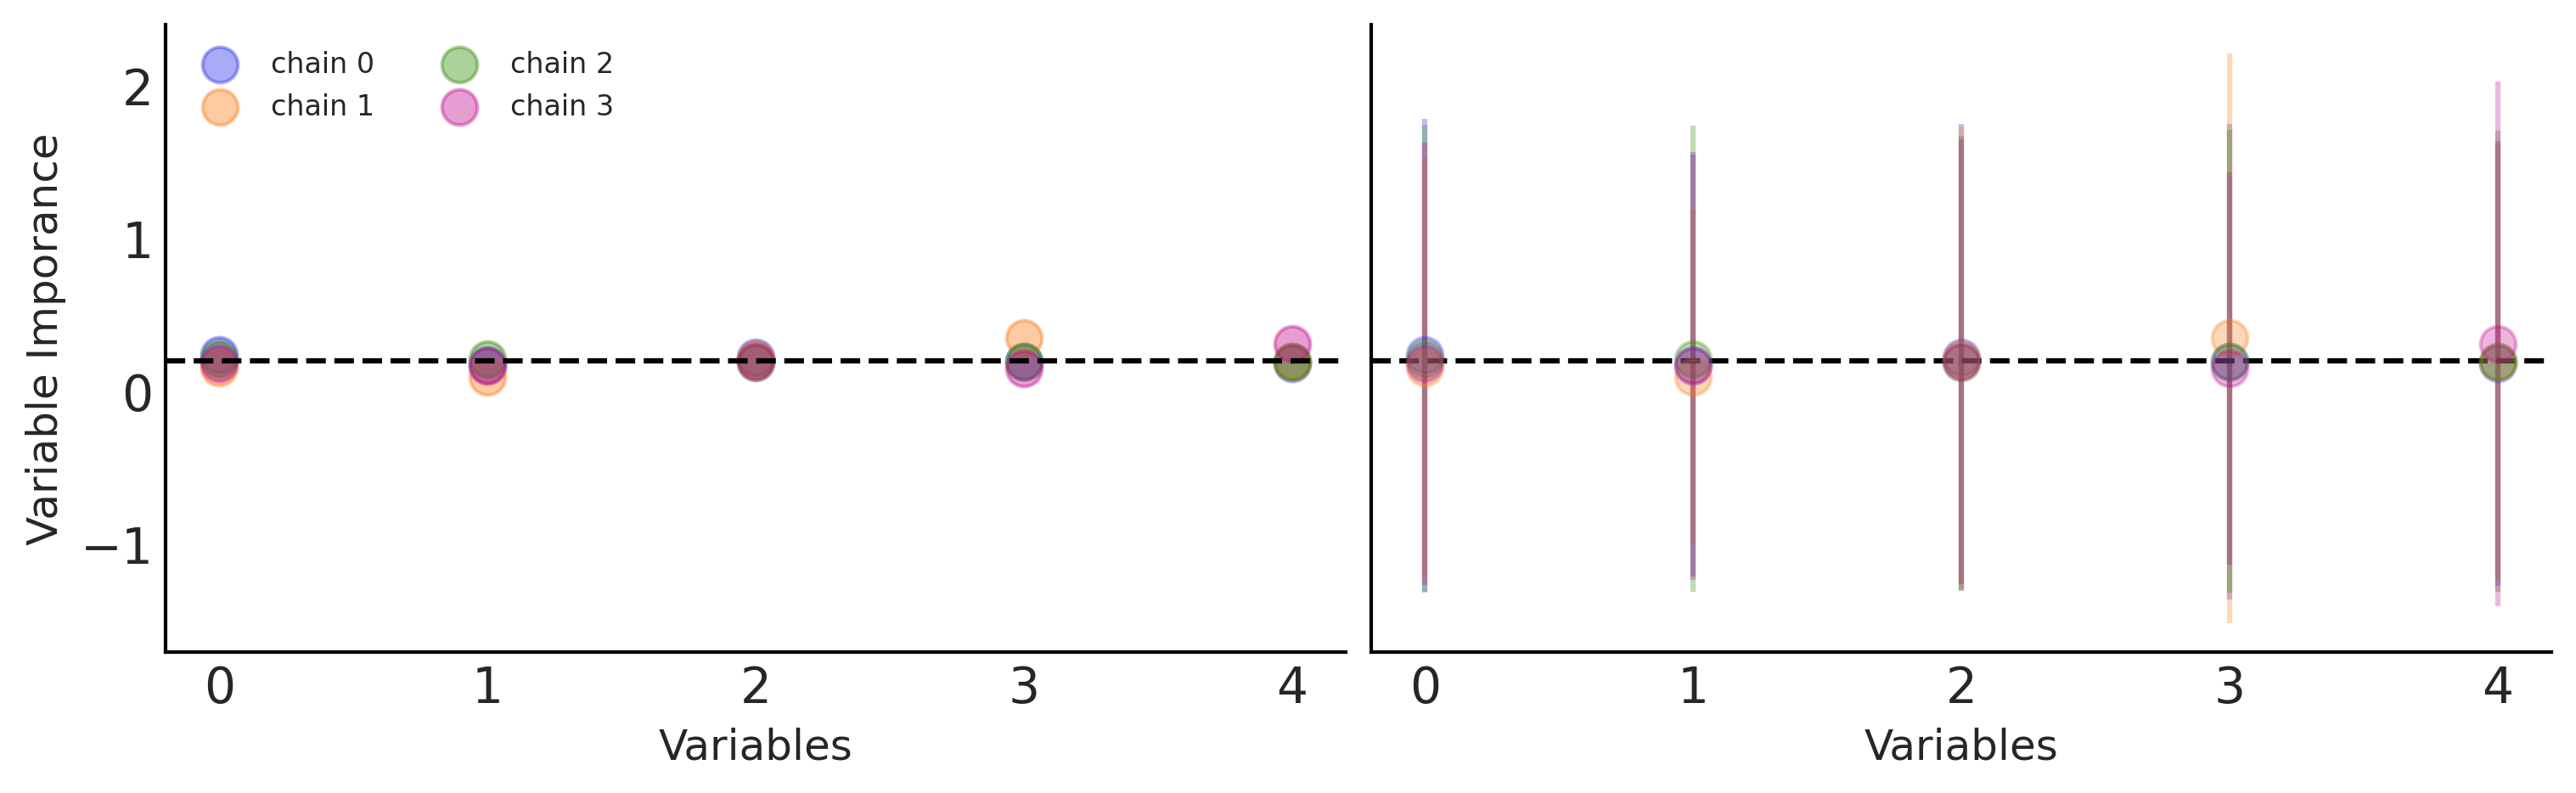

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 3))

for i in range(0, len(vis_chains)):
    axes[0].scatter(Xs, vis_chains[i], s=100, alpha=0.4, label=f"chain {i}")
    axes[1].errorbar(
        x=Xs,
        y=vis_chains[i],
        yerr=vis_chains_std[i],
        linestyle="None",
        marker="o",
        markersize="10",
        alpha=0.3,
    )

for ax in axes:
    ax.axhline(1 / X.shape[1], ls="--", color="k")
    ax.set_xticks(Xs)
    ax.set_xlabel("Variables", fontsize=12)

axes[0].legend(loc="upper left", ncol=2, fontsize=8)
axes[0].set_ylabel("Variable Imporance", fontsize=12)
plt.savefig("similar_VI_by_chain.png");

In [10]:
# Save the VI ordered by half of each chain
vis_half_chains = []
vis_std_half_chains = []
# Calculate the mean VI for each half-chain
for chain in chains:
    vi_0 = idata.sample_stats["variable_inclusion"][chain][0:499].mean("draw")
    vi_1 = idata.sample_stats["variable_inclusion"][chain][500:999].mean("draw")
    vis_half_chains.append(vi_0 / vi_0.sum())
    vis_half_chains.append(vi_1 / vi_1.sum())
    vi_0_std = idata.sample_stats["variable_inclusion"][chain][0:499].std("draw")
    vi_1_std = idata.sample_stats["variable_inclusion"][chain][500:999].std("draw")
    vis_std_half_chains.append(vi_0_std / vi_0_std.sum())
    vis_std_half_chains.append(vi_1_std / vi_1_std.sum())
# Labels
names = ["1-a", "1-b", "2-a", "2-b", "3-a", "3-b", "4-a", "4-b"]

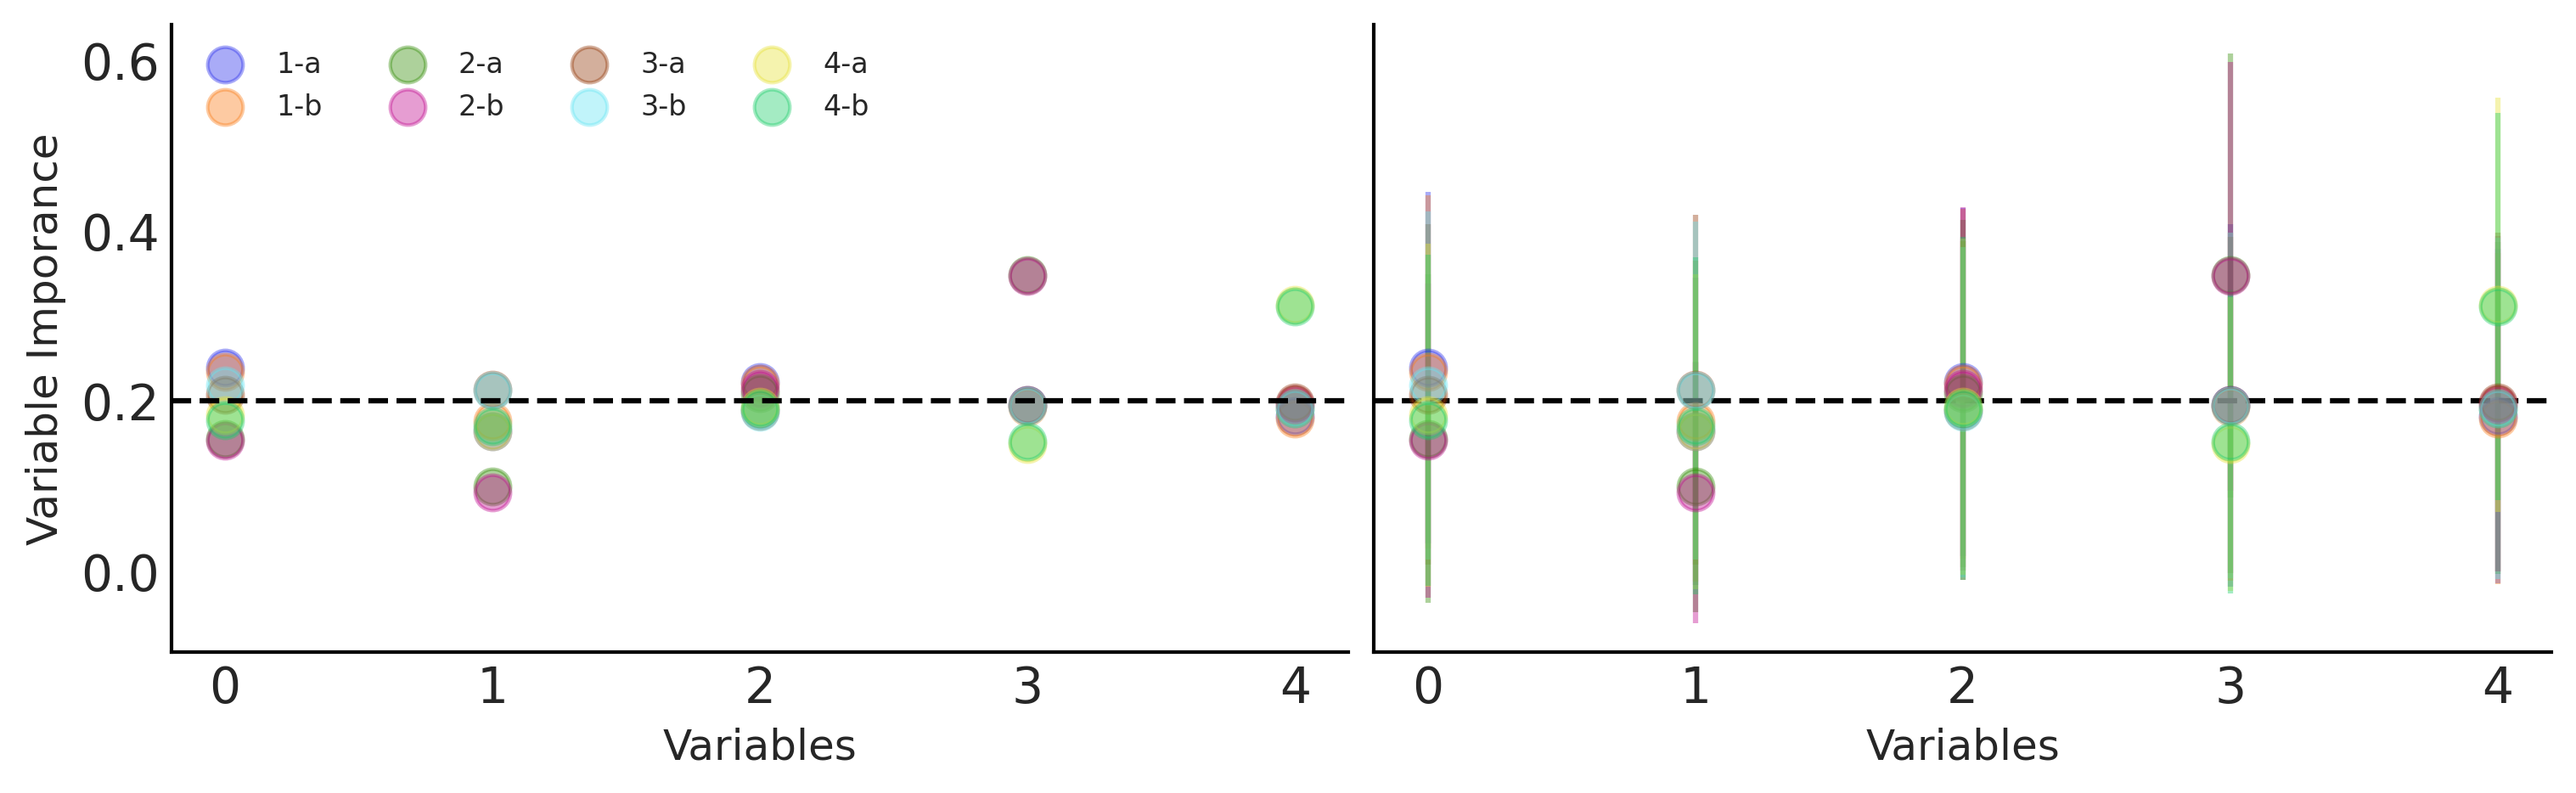

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 3))

for i in range(0, len(vis_half_chains)):
    axes[0].scatter(Xs, vis_half_chains[i], s=100, alpha=0.4, label=f"{names[i]}")
    axes[1].errorbar(
        x=Xs,
        y=vis_half_chains[i],
        yerr=vis_std_half_chains[i],
        linestyle="None",
        marker="o",
        markersize="10",
        alpha=0.4,
    )

for ax in axes:
    ax.axhline(1 / X.shape[1], ls="--", color="k")
    ax.set_xticks(Xs)
    ax.set_xlabel("Variables", fontsize=12)

axes[0].legend(loc="upper left", ncol=4, fontsize=8)
axes[0].set_ylabel("Variable Imporance", fontsize=12)
# plt.ylim(-1.5, 2.1)# same limits as the previous plots
plt.savefig("similar_VI_half_chains.png");